## GHP Construction with Duration Matching

In [37]:
import numpy as np
import pandas as pd
import edhec_risk_ins as eri
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
eri.bond_cash_flows(3,100,0.03,2)
# generate the cash flows during the life time of the bond
# maturity,principal,coupon_rate,coupons per year

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [5]:
eri.bond_price(3,100,.03,2,.03)
# maturity,principal,coupon rate,per year,discount rate

0    100.0
dtype: float64

In [6]:
eri.bond_price(20,1000,0.05,2,0.04)

0    1136.777396
dtype: float64

In [7]:
eri.bond_price(20,1000,0.05,2,0.05)

0    1000.0
dtype: float64

In [8]:
eri.bond_price(20,1000,0.05,2,0.01)

0    1723.444557
dtype: float64

In [9]:
rates = np.linspace(.01,.1,num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [10]:
prices = [eri.bond_price(10,1000,.05,2,rate)for rate in rates]
prices

[0    1379.748383
 dtype: float64,
 0    1326.762928
 dtype: float64,
 0    1276.163298
 dtype: float64,
 0    1227.833538
 dtype: float64,
 0    1181.663651
 dtype: float64,
 0    1137.549279
 dtype: float64,
 0    1095.3914
 dtype: float64,
 0    1055.096038
 dtype: float64,
 0    1016.573997
 dtype: float64,
 0    979.740605
 dtype: float64,
 0    944.515473
 dtype: float64,
 0    910.822268
 dtype: float64,
 0    878.588497
 dtype: float64,
 0    847.745306
 dtype: float64,
 0    818.227287
 dtype: float64,
 0    789.972298
 dtype: float64,
 0    762.92129
 dtype: float64,
 0    737.018147
 dtype: float64,
 0    712.209532
 dtype: float64,
 0    688.444741
 dtype: float64]

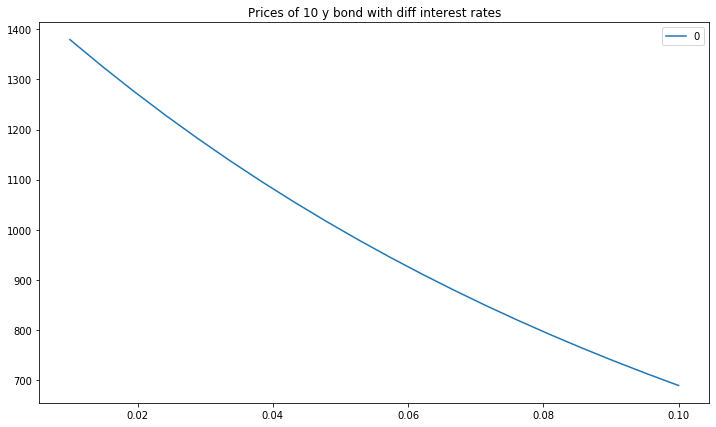

In [11]:
pd.DataFrame(data=prices, index=rates).plot(title="Prices of 10 y bond with diff interest rates", legend ="false",figsize=(12,7))

In [12]:
cf = eri.bond_cash_flows(3,1000,.06,2)

In [13]:
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [31]:
discounts = eri.discount(cf.index, .06/2)

In [32]:
discounts

1    0.970874
2    0.942596
3    0.915142
4    0.888487
5    0.862609
6    0.837484
dtype: float64

In [33]:
dcf = cf * discounts
dcf #present value of cf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [20]:
weights = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [21]:
(cf.index*weights).sum() #ma duration

5.579707187194534

In [22]:
eri.macaulay_duration(eri.bond_cash_flows(3,1000,.06,2),.06/2)

5.579707187194534

## Duration Match

In [63]:
liabilities = pd.DataFrame(data=[10000,10000],index = [10,12])
liabilities

,0
10,10000
12,10000


In [65]:
eri.macaulay_duration(liabilities,.04)

10.960799385088393

In [66]:
md_10 = eri.macaulay_duration(eri.bond_cash_flows(10,1000,.05,1),.04)
md_20 = eri.macaulay_duration(eri.bond_cash_flows(20,1000,.05,1),.04)

In [67]:
md_10,md_20

(8.190898824083233, 13.544718122145921)

#### In this case, the fraction in the short duration asset w, should be such that:

$$ w_s * 8.19 + (1-w_s) * 13.54 = 10.96 $$ 

more generally:

$$ w_s * d_s + (1-w_s) * d_l = d_t $$

while: 
$$w_s = \frac{d_l - d_t}{d_l - d_s}$$

In [69]:
short_bond = eri.bond_cash_flows(10,1000,.05,1)
long_bond = eri.bond_cash_flows(20,1000,.05,1)
w_s = eri.match_durations(liabilities,short_bond, long_bond,.04)
w_s

0.48263092069478974

In [75]:
p_short = eri.bond_price(10,1000,.05,1,.04)
p_long = eri.bond_price(20,1000,.05,1,.04)
print(p_short)
print(p_long)

0    1081.108958
dtype: float64
0    1135.903263
dtype: float64


In [86]:
short_bond/(p_short.iloc[-1])

1     0.046249
2     0.046249
3     0.046249
4     0.046249
5     0.046249
6     0.046249
7     0.046249
8     0.046249
9     0.046249
10    0.971225
dtype: float64

In [87]:
p_short = eri.bond_price(10,1000,.05,1,.04)
p_long = eri.bond_price(20,1000,.05,1,.04)
a_0 = 130000
port_flows = pd.concat([a_0*w_s*short_bond/p_short.iloc[-1],a_0*(1-w_s)*long_bond/p_long.iloc[-1]])
eri.macaulay_duration(port_flows,.04)

10.960799385088393

In [71]:
cfr = eri.funding_ratio(port_flows,liabilities,.04)

In [72]:
cfr

0    0.0
dtype: float64

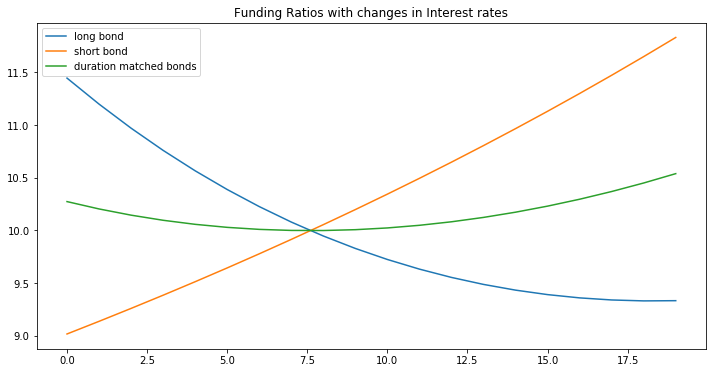

In [33]:
rates = np.linspace(0,.1,20)
lb_assets = a_0*long_bond/p_long
sb_assets = a_0*short_bond/p_short 

fr_change = pd.DataFrame({
    "long bond":[eri.funding_ratio(lb_assets,liabilities,r) for r in rates],
    "short bond":[eri.funding_ratio(sb_assets, liabilities,r) for r in rates],
    "duration matched bonds":[eri.funding_ratio(port_flows, liabilities,r) for r in rates]
})

fr_change.plot(title="Funding Ratios with changes in Interest rates",figsize=(12,6))